# Titanic: Who boarded and who survived? 

The dataset that I am going to analyze here has information on 891 out of 2224 passengers and crew who boarded the ill-fated Titanic. The dataset gives us information on whether or not a person survived, what passenger class they boarded on, gender, age, number of family members on-board, passenger fare, and where each passenger boarded the ship. 

Most obvious question of interest would be which group of people are more likely to survive.  It would be interesting to study:

**1) Are first class/higher fare passengers more likely to survive?**

**2) Is there a relationship between survival and age?**

**3) Are both genders equally likely to survive?** 


It would be interesting to know if people with more family members on board are more likely to survive.

First, let us start with reading in the information into a Pandas dataframe, as the groupby function should be very useful with a dataset such as this.

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import scipy.stats as stats

all_data=pd.DataFrame.from_csv("titanic-data.csv")
display(all_data.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Some exploration of the data may be useful in case there are unexpected anomalies, so I can try to print out distributions of certain factors.

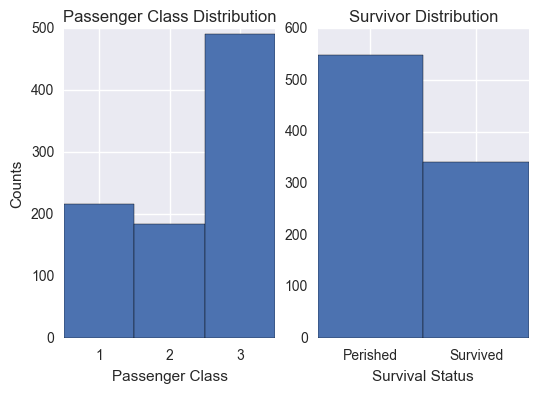

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, sharex=False)
plt.subplots_adjust(hspace = 500)
sums_class=all_data.groupby("Pclass").count()
x_class=sums_class.index.values
sums_survivor=all_data.groupby("Survived").count()

#Bar Chart for Passenger Class
axes[0].bar(sums_class.index.values, sums_class['Survived'], width=1.0)
axes[0].set_xlabel('Passenger Class')
axes[0].set_title('Passenger Class Distribution')
axes[0].set_ylabel('Counts')
plt.sca(axes[0])
plt.xticks(sums_class.index.values+0.5, sums_class.index.values)

#Bar chart for those who perished vs those who survived
axes[1].bar(sums_survivor.index.values, sums_survivor['Fare'], width=1.0)
axes[1].set_xlabel('Survival Status')
axes[1].set_title('Survivor Distribution')
plt.sca(axes[1])
plt.xticks(sums_survivor.index.values+0.5, ["Perished","Survived"])
#all_data['Pclass'].(ax=axes[0],kind="bar",x="Class",xticks=[1,2,3])
#all_data['Survived'].plot(ax=axes[1],kind="bar",x="Survival",xticks=[0,1])
plt.show()

## Passenger Class

The distribuiton of survivor by class:

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Name, dtype: int64 <class 'pandas.core.series.Series'>


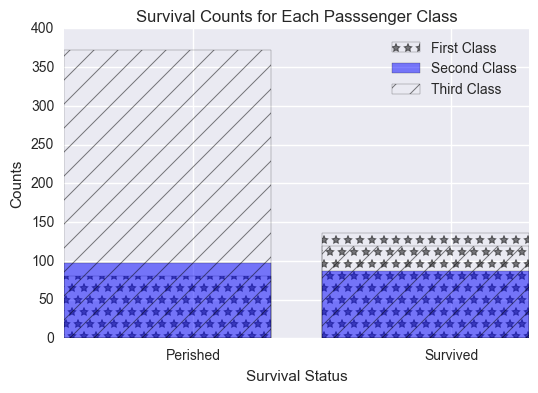

In [91]:
plt.figure()
#by_class["Survived"].plot.hist(alpha=0.4,bins=2)
#Grouping by both class and survivor, so we can take counts and index to construct
#a bar chart that shows how many survived/perished from each class

#We can pick total counts from any column
#except those with missing values. Let us just pick Counts from the name column

survival_class_counts=all_data.groupby(["Pclass","Survived"])["Name"].count()
print survival_class_counts, type(survival_class_counts)
'''
surv_num=pd.Series([0,0,0])
per_num=pd.Series([0,0,0])
n=0

for key, values in survival_class_counts:
    print values
    if key[1]==0:
        per_num[n]=values
    else:
        surv_num[n]=values
    n+=1
'''       
plt.title("Survival Counts for Each Passsenger Class")
plt.bar([0,1],[survival_class_counts.loc[(1,0)],survival_class_counts.loc[(1,1)]],fill=False,color="red",hatch="*",alpha=0.5,label="First Class")
plt.bar([0,1],[survival_class_counts.loc[(2,0)],survival_class_counts.loc[(2,1)]],color="blue",alpha=0.5,label="Second Class")
plt.bar([0,1],[survival_class_counts.loc[(3,0)],survival_class_counts.loc[(3,1)]],fill=False,color="green",alpha=0.5,hatch="/",label="Third Class")

#plt.bar([0,1],[per_num[0],surv_num[0]],color="blue",alpha=0.5,label="First Class")
#plt.bar([0,1],[per_num[1],surv_num[1]])
#plt.bar([0,1],[per_num[2],surv_num[2]])

plt.xticks([0.5,1.5], ["Perished","Survived"])
plt.xlabel('Survival Status')
plt.ylabel('Counts')
plt.legend()
plt.show()
#We also want to label correctly, and use diferennt colors
#plt.legend()

Number of survivors and total population in each class:

In [374]:
by_class=all_data.groupby("Pclass")
class_survival_mean=by_class.mean()["Survived"]
print "Fraction of Survivors by class:", class_survival_mean
non_survivors_fraction=1-class_survival_mean
print "Non survivors", non_survivors_fraction
class_survival_sizes=by_class.size()
print "Total Populations:", class_survival_sizes

Fraction of Survivors by class: Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Non survivors Pclass
1    0.370370
2    0.527174
3    0.757637
Name: Survived, dtype: float64
Total Populations: Pclass
1    216
2    184
3    491
dtype: int64


The mean in this case gives us total number of people who survived in each group/total number of people in that group. A higher fraction of first class passengers survived than fraction second class passengers, and an even smaller fraction of third class passengers survived. But the number of first and third class passengers are very close to each other.

To test if two samples are drawn from the same population or not for binary data, there is a statistical test called Fisher's exact test, which we can use to compare the survival chances between classes.

The null hypothesis in this case would be that:
$$H_0: \mu_{first-class} = \mu_{second-class}$$
$$H_A: \mu_{first-class} >\mu_{second-class}$$

where $\mu$ is the number of survivors, and the same hypothesis applies to any two classes (upper class has higher chances of survival for each alternative hypothesis). The p-value that the distribution of survivors to non-survivors are drawn from the same distribution is given by p-value returned by fisher exact test.

In [380]:
#vector multiplication to get numbers of survivors/non-survivors
survivor_numbers=class_survival_mean*class_survival_sizes
passed_away_numbers=non_survivors_fraction*class_survival_sizes
#Funciton to take in these two series and give us pvalue:
def fisher(class1, class2, survivor_numbers,passed_away_numbers, altern):
    oddsratio, pvalue = stats.fisher_exact([[survivor_numbers.loc[class1],passed_away_numbers.loc[class1]], [survivor_numbers.loc[class2], passed_away_numbers.loc[class2]]], alternative=altern)
    return pvalue

print survivor_numbers, passed_away_numbers
print "Assuming Null Hypothesis,"
print "Probability that 1st and 2nd class passengers had same chances of survival:", fisher(1, 2, survivor_numbers,passed_away_numbers, "greater")
print "Probability that 1st and 3rd class passengers had same chances of survival:", fisher(1, 3, survivor_numbers,passed_away_numbers, "greater")
print "Probability that 2nd and 3rd class passengers had same chances of survival:", fisher(2, 3, survivor_numbers,passed_away_numbers, "greater")

Pclass
1    136.0
2     87.0
3    119.0
dtype: float64 Pclass
1     80.0
2     97.0
3    372.0
dtype: float64
Assuming Null Hypothesis,
Probability that 1st and 2nd class passengers had same chances of survival: 0.00114805201764
Probability that 1st and 3rd class passengers had same chances of survival: 1.37993734185e-22
Probability that 2nd and 3rd class passengers had same chances of survival: 1.17822971466e-08


I think by looking these probability levels, we can say that the **difference in survival rates between classes is statistically significant**. Therefore, we can reject the null hypothesis that there was no difference in survival rates based on passenger class. This only suggest a correlation, unless we can find evidence that upper class passengers were definitely given preference - which would be a causal link.

It might be interesting to see which passengers among just the first class passengers did not survive. Those with lower fares? Older passengers?

## Fare

To find out if the data shows any unexpected trends, let us first look at fare distribution.

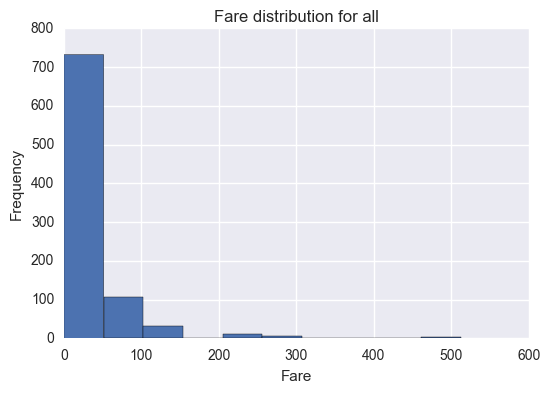

In [72]:
plt.figure()
plt.title("Fare distribution for all")
all_data['Fare'].plot.hist()
plt.xlabel("Fare")

In [66]:
all_data['Fare'].groupby([all_data["Survived"],all_data["Pclass"]]).describe()

Survived  Pclass       
0         1       count     80.000000
                  mean      64.684008
                  std       60.662089
                  min        0.000000
                  25%       27.742700
                  50%       44.750000
                  75%       78.937500
                  max      263.000000
          2       count     97.000000
                  mean      19.412328
                  std       15.307175
                  min        0.000000
                  25%       11.500000
                  50%       13.000000
                  75%       26.000000
                  max       73.500000
          3       count    372.000000
                  mean      13.669364
                  std       12.118338
                  min        0.000000
                  25%        7.750000
                  50%        8.050000
                  75%       15.136450
                  max       69.550000
1         1       count    136.000000
                  mean    

A function which takes a group object, and a field, and for each group, returns a histogram for that field might be useful.

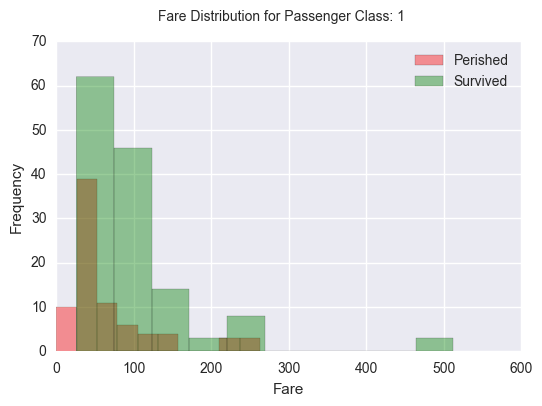

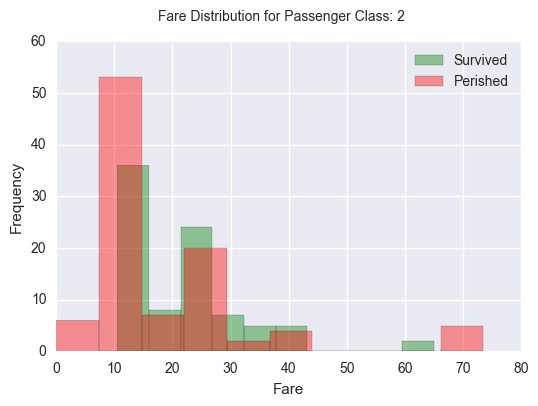

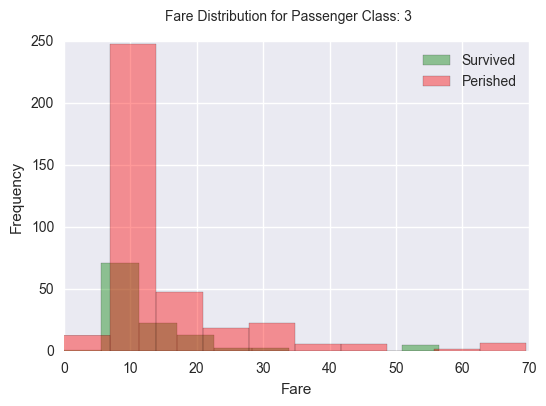

In [73]:
class_survive=all_data.groupby([all_data["Survived"],all_data["Pclass"]])
#A function to take a grouped object, field name and class, and create histograms by class
#For survivors and non-survivors
def hist_of_groups(fieldname, pclass, alph, groupedobject):
    plt.figure()
    survivor=pd.Series(["Perished","Survived"])
    plot_title=fieldname+" Distribution for Passenger Class: "+str(int(pclass))
    plt.suptitle(plot_title)
    plt.xlabel(fieldname)
    for key,value in groupedobject.groups.iteritems():
        if key[1]==pclass:
            real_info=all_data[fieldname].loc[value]
            if key[0]==0:
                colour="red"
            else:
                colour="green"
            real_info.plot.hist(x=fieldname, alpha=alph,label=survivor.iloc[key[0]],color=colour)
    plt.legend()

hist_of_groups("Fare",1,0.4,class_survive)
hist_of_groups("Fare",2,0.4,class_survive)
hist_of_groups("Fare",3,0.4,class_survive)

Here 1 indicates survivor and 0 means the passenger passed away. Simply looking at the histograms, we get an idea about how the fares were distributed, but cannot draw conclusions on whether or not it had an impact on survival. From the histograms of the first and second class, it seems that there might have been more survivors than non-survivors among passengers who paid higher fares. We need to investigate if this could be ruled as random chance or if the difference in fare paid and survival is statistically significant. To get some more insights, we can also represent the data using boxplots.

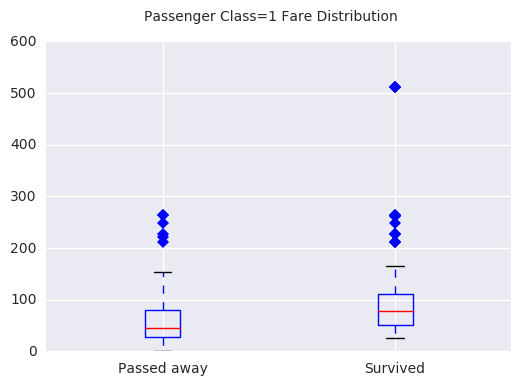

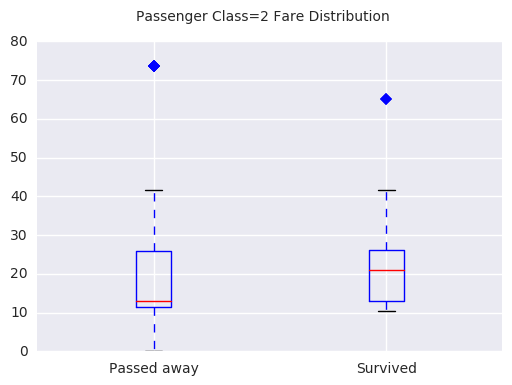

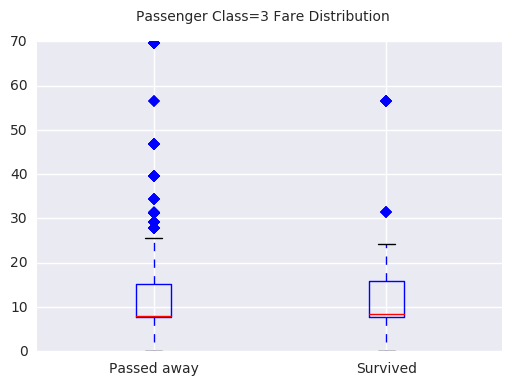

In [183]:
def box_plot_by_class(fieldname, pclass, groupedobject):
    n=0
    plt.figure()
    for key,value in groupedobject.groups.iteritems():
        plot_title="Passenger Class="+str(int(pclass))+" "+fieldname+" Distribution"
        plt.suptitle(plot_title)
        if key[1]==pclass and key[0]==0:
            passed_away=all_data[fieldname].loc[value]
        if key[1]==pclass and key[0]==1:
            survived=all_data[fieldname].loc[value]
    data = [passed_away, survived]
    plt.boxplot(data, 0, 'gD')
    plt.xticks([1, 2], ['Passed away', 'Survived'])
    
box_plot_by_class("Fare",1,class_survive)
box_plot_by_class("Fare",2,class_survive)
box_plot_by_class("Fare",3,class_survive)

I am intersted in the most expensive fare first class passenger, let us look at her/his entry. It might be intersting to look at the maximum or minimum from each column, or the top few or the bottom few in age, fare. So I will write a function which would help us look up some specific people of interest.

In [293]:
#To look up the top or bottom few people in age, fare, just to see if there
#is something interesting we might be missing
def interesting_cases(fieldname, data_frame, percentile_of_interest, number_to_look_up=10):
    if percentile_of_interest<0 or percentile_of_interest>100:
        raise ValueError("Percentile values must be between 0 and 100.")
    else:
        if percentile_of_interest>99:
            sorted_frame=data_frame.sort_values(fieldname, ascending=False)
            return display(sorted_frame.head(number_to_look_up))
        elif percentile_of_interest<1:
            sorted_frame=data_frame.sort_values(fieldname)
            return display(sorted_frame.head(number_to_look_up))
        else:
            sorted_frame=data_frame.sort_values(fieldname)
            num=data_frame[fieldname].count()
            real_number=num*percentile_of_interest/100.0
            end_num=round(real_number)-round(number_to_look_up/2)
            if end_num<0:
                end_num=0
            real_indices=end_num+np.arange(number_to_look_up)
            print real_indices
            output_rows=sorted_frame.iloc[real_indices]
            return display(output_rows)

#Another way to do this:

        
#all_data.apply(interesting_cases("Fare",100,4))
interesting_cases("Fare", all_data, 100, 10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


The above table gives us some idea about how we can find family members - it might be useful to group by cabin numbers or tickets. We will not explore this variable in this analysis though!

Using the means and standard deviations fares of passengers who survived and passengers who didn't, in each class, we could compare if the difference in fare between those who survived and those who did not made a significant difference. Since there are two different groups of people, we treat them as independent samples. The assumptions about the distribution is:

$$H_0: \mu_{fare-survived} = \mu_{fare-passed-away}$$
$$H_A: \mu_{fare-survived} > \mu_{fare-passed-away}$$

We can do a t-statistic test for independent samples. t-statistic required a near normal distribution, or a sufficiently large sample (> 40) - which is true for all of our samples.

Let us start with looking at fare differces by class first, we can consider the whole population afterwards. 

In [327]:
#this function takes in a field name, a particular passenger class and a grouped object
#type object and returns t-statistic and degrees of freedom
#I know python has a t-statistic function, but for practice I wanted to work with 
#grouped items a little more
def t_stat_of_groups(fieldname, pclass, groupedobject):
    means=pd.Series([0.0,0.0])
    stdevs=pd.Series([0.0,0.0])
    sizes=pd.Series([0.0,0.0])
    key_order=pd.Series([0.0,0.0])
    n=0
    for key,value in groupedobject.groups.iteritems():
        if key[1]==pclass:
            key_order[n]=key[0]
            fare_only=all_data[fieldname].loc[value]     
            average=fare_only.mean()
            means[n]=average
            stndard_dev=fare_only.std()
            stdevs[n]=stndard_dev
            siz=fare_only.count()
            sizes[n]=siz
            n+=1
    standard_error=sqrt(pow(stdevs[0],2)/sizes[0]+pow(stdevs[1],2)/sizes[1])
    #print standard_error
    #the key order subtraction needs to be done because the grouping is strange
    #not all survival 0 appear consecutively, so I am not sure which direction to 
    #subtract from. But this is a one tailed test so it must be survived-did not survive
    #hence this correction factor
    t_stat=(key_order[0]-key_order[1])*(means[0]-means[1])/standard_error
    deg_of_free=sizes.sum()-2
    return t_stat, deg_of_free

Running on passenger class 1 (this function returns t-statistic for the surviving and non-surviving cases for and the degree of freedom for a particular cases):

In [189]:
fare_first_class_t=t_stat_of_groups("Fare",1,class_survive)
print fare_first_class_t

(3.1004311018316248, 214.0)


From Graphpad, I found that this value of t corresponds to a probability of 0.0022 that these two fare distributions are drawn from the same sample - i.e. the difference in fares is statistically significant. However, this is a one tailed test. If we assume that this is an approximately symmetrical distribution (which is not really accurate in this case), then the probability of a one-tailed t-test is half the value of probability of the two-tailed t-test. So, the probability corresponding to this t-value for a one-tailed t-test must be even smaller. In any case, I think this t-statistic indicate that at least at an $\alpha$ level of 0.05. **So, we can reject the null hypothesis. The fare is statistically significant for those who survived and those who did not for Passenger from first class**. 

A statistical significance does not imply causality, but we can measure effect using $r^2$ value:

$$r^2 = \frac{t^2}{t^2 + df}$$

In [191]:
def rsquare(tval,df):
    return pow(tval,2)/(pow(tval,2)+2)
    
    
rsquare(fare_first_class_t[0],fare_first_class_t[1])

0.8277743636596947

The $r^2$ indicates a 83% correlation between fare and survival of a first class passenger. This still does not indicate causality, just very strong correlation.

Now let us explore the difference for passengers from second and third classes:

In [180]:
print t_stat_of_groups("Fare",2,class_survive)
print t_stat_of_groups("Fare",3,class_survive)

(1.3614837907273991, 182.0)
(0.021921324946250934, 489.0)


For the second class passengers, the t-statistic is 1.36 and degree of freedom is 182. The two-tailed t-test probability for this value is 0.176, half of which (for one-tailed test) is still 0.088, greater than an $\alpha$ level of 0.05. So fare did not make a significant difference for the second class passengers.

For the third class passengers, the t-statistic is 0.02 and degree of freedom is 489. The p value for two-tailed test is 0.9825 - so this cannot be considered a statistically significant difference.

## Age

To start the analysis by age, we tried this:

In [233]:
all_age_data['Age'].groupby([all_age_data["Survived"],all_age_data["Pclass"]]).describe()

Survived  Pclass       
0         1       count     64.000000
                  mean      43.695312
                  std       15.284243
                  min        2.000000
                  25%             NaN
                  50%             NaN
                  75%             NaN
                  max       71.000000
          2       count     90.000000
                  mean      33.544444
                  std       12.151581
                  min       16.000000
                  25%             NaN
                  50%             NaN
                  75%             NaN
                  max       70.000000
          3       count    270.000000
                  mean      26.555556
                  std       12.334882
                  min        1.000000
                  25%             NaN
                  50%             NaN
                  75%             NaN
                  max       74.000000
1         1       count    122.000000
                  mean    

It seems we have encountered an issue with Age entries, to investigate, we print out more lines (I printed out a lot more at first, but the first 7 are enough to demonstrate the problem):

In [193]:
display(all_data.head(7))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


For the age analysis, we cannot do anything with the passengers for whom we do not have age information. To find the locations of rows for which we do have age information:

In [88]:
no_nan=np.where(~np.isnan(all_data["Age"]))
print "Number remaining after removing NaN:", np.size(no_nan)
all_age_data=all_data.iloc[no_nan]
display(all_age_data.head(7))
#all_age_data.groupby("Survived")["Age"].apply(plt.hist) --not very useful

Number remaining after removing NaN: 714


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


The new table shows that we were able to get rid of the NaN values for age. We lost 177 entries in process of removing these NaN values. A bigger sample is more likely to give us an accurate representation, although we still retain more than 80% of the data.

Just out of curiosity, we can look at the five oldest and youngest passengers:

In [386]:
print "Oldest Passengers:"
interesting_cases("Age", all_data, 100, 5)

Oldest Passengers:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S
494,0,1,"Artagaveytia, Mr. Ramon",male,71.0,0,0,PC 17609,49.5042,NaN,C
97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q


In [387]:
print "Youngest Passengers:"
interesting_cases("Age", all_data, 0, 5)

Youngest Passengers:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S


All of the youngest passengers survived! And so did the oldest person.

In [334]:
all_age_data['Age'].groupby([all_age_data["Survived"],all_age_data["Pclass"]]).mean()

Survived  Pclass
0         1         43.695312
          2         33.544444
          3         26.555556
1         1         35.368197
          2         25.901566
          3         20.646118
Name: Age, dtype: float64

These mean values are very interesting because at first glance it looks like first class generally has older people than second class, which in turn has older people than third class. To explore this further, we look total age distributions:

In [336]:
all_age_data.groupby("Pclass")["Age"].apply(mean)

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

This is an interesting, but I am not going to explore if the difference in age between the three classes is statistically significant. It might hold some interesting information so I am noting this.

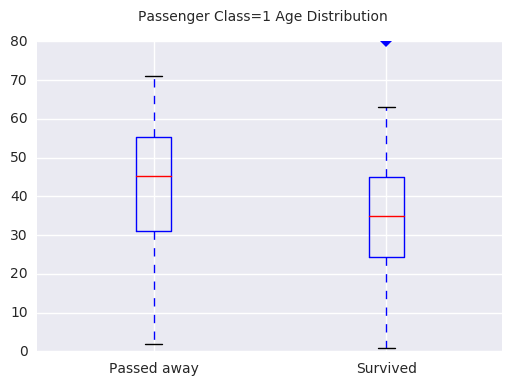

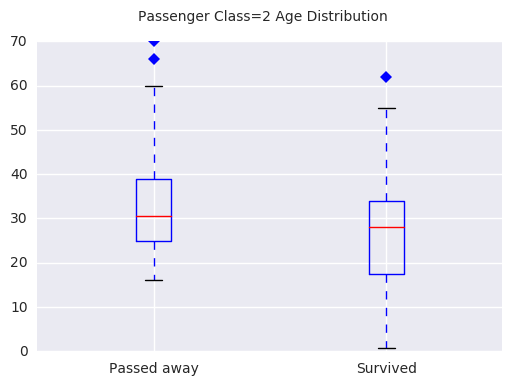

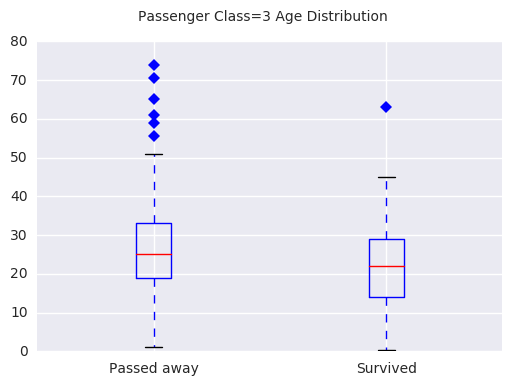

In [305]:
age_class_survive=all_age_data.groupby([all_data["Survived"],all_data["Pclass"]]) 
box_plot_by_class("Age",1,age_class_survive)
box_plot_by_class("Age",2,age_class_survive)
box_plot_by_class("Age",3,age_class_survive)

It seems the older folks are more likely to pass away by some margin. To figure out whether or not it is a statistically significant margin, let us use the t-statistic. The null hypothesis and alternative hypothesis:
$$H_0: \mu_{age-survived} = \mu_{age-passed-away}$$
$$H_A: \mu_{age-survived} < \mu_{age-passed-away}$$

This is a one tailed test, and this time to reject the null hypothesis, we need a negative t-value that is at has $\alpha$ level of 0.5.

In [339]:
first_cl_age=t_stat_of_groups("Age", 1, age_class_survive)
print "First Class (t, df):", first_cl_age
second_cl_age=t_stat_of_groups("Age", 2, age_class_survive)
print "Second Class:", second_cl_age
third_cl_age=t_stat_of_groups("Age", 3, age_class_survive)
print "Third Class:", third_cl_age

 First Class (t, df): (-3.6509525714666076, 184.0)
Second Class: (-3.6886383406060586, 171.0)
Third Class: (-3.9341776649088995, 353.0)


From Graphpad, using (t, df) values above for each class, this is the probability for two tailed test:
First class: 0.0003
Second class: 0.0003
Third class: 0.0001

For a one-tailed test (for an approximately symmetrical distribution) should be half of these probability values. Thes values tell us that the difference in age between those who survived and those who did not is extremely statistically significant. The $r^2$ value for each class would be:

In [342]:
print "First class:", rsquare(first_cl_age[0],first_cl_age[1])
print "Second class:", rsquare(second_cl_age[0],second_cl_age[1])
print "Third class:", rsquare(third_cl_age[0],third_cl_age[1])

First class: 0.86953221482
Second class: 0.871844596156
Third class: 0.885568820138


For all three classes, survival has a strong correlation with age. This does not necessarily show a causal link.

## Gender
We could group passengers by gender, and find out what the male to female ratio was on the ship. It would also be intersting to know if men or women were more likely to travel with family members.

In [379]:
print "Total counts by gender:"
total_by_gender=all_data.groupby([all_data['Sex']])['Survived'].count()
print total_by_gender
print "Numbers that survived by gender:"
print all_data.groupby([all_data['Sex']])['Survived'].sum()
print "Fraction of survivors by gender:"
fraction_by_gender=all_data.groupby([all_data['Sex']])['Survived'].mean()
print fraction_by_gender

Total counts by gender:
Sex
female    314
male      577
Name: Survived, dtype: int64
Numbers that survived by gender:
Sex
female    233
male      109
Name: Survived, dtype: int64
Fraction of survivors by gender:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


Running Fisher test to find if we can say that the difference in survival rates gender is statistically significant:
$$H_0: \mu_{female} = \mu_{male}$$
$$H_A: \mu_{female} > \mu_{male}$$


In [382]:
survivor_numbers=fraction_by_gender*total_by_gender
passed_away_numbers=(1.0-fraction_by_gender)*total_by_gender
print "Probability that both genders had same chances of survival:", \
    fisher("female", "male", survivor_numbers,passed_away_numbers, "greater")

Probability that both genders had same chances of survival: 6.94765817787e-60


We can reject the null hypothesis that both genders had the same chances of survival. The alternative, that being female was correlated with a higher chance of survival is supported by Fisher's Exact test. This is just a correlation, not a causal link, unless we could find evidence that preference was given to women to board lifeboats.

In [388]:
#cabin_survive=all_data.groupby(all_data["Ticket"])
#list(cabin_survive)

## Conclusions

This data set can be explored in many more ways. In this work, I have decided to look into whether or not age, passenger class, fare and gender has any correlations with surviving. My analysis suggests that **a higher fraction of first class passengers survived (63%) than did second class passengers (47%), and a higher fraction of second class passengers survived than third class passengers (24%). Also, a significantly higher fraction of women survived (74%) than men (19%)**. The statistical significance of both of these conclusions were supported by Fisher's Exact test.

I also found that **fare differences between survivors and non-survivors within the first class was statistically significant (one-tailed student's t-test)**. But **fare differences between survivors among the other two classes was not statistically significant**. I also carried out t-test on age differences between survivors and non-survivors in each passenger class, and found that the difference is statistically significant in all three classes - **there is a strong anti-correlation between age of passengers in each class and survival**.

There was something more that I would have liked to explore if I had more time for this project: whether or not people are more likely to survive if they travel with family members, especially young children. In the fare section, after looking at a print out of a couple of entries that included several members of a family, I realized one way to identify entire families traveling together would be using the *Ticket* or *Cabin* fields. Then we could look at whether men within families have a higher or lower chance of survival than men traveling along (because families with children migh have been given priority). I started looking at this aspect (in cell 388) - but I have to leave it for now.

Note that this data might not be representative of the whole population of Titanic. We have data for only 891 people, and I am not sure how the data was collected. It could be from any surviving documents that was not in the Titanic itself - where  the survival information was later added during official investigation. Or maybe actual survivors or relatives of those who perished were later interviewed to collect all this information. There could be selection bias, such as wealthier, well-connected folks are more likely to be documented using the latter survey technique. Even survivors might be more likely to be documented than those who perished in such a survey. It might not be a completely random sample of 891 selected from the population of 2224, in which case all the trends we see in this data might not be exist to the same extent in the whole population.